# Lab 5: Spatial Autocorrelation #


In this lab we will practise to analyze global and local spatial autocorrelation to analyze spatial data.

The analyses of spatial autocorrelation are also called Exploratory Spatial Data Analysis (ESDA).

This lab is modified from the [tutorial of pysal ESDA](https://pysal.org/).

#### Before the lab, please install the python module esda and splot.

Open anaconda prompt in your start menu as an administrator user. 

Remember to open the right version (Anaconda 3.6) if you have multiple anaconda installed.

Install the module **esda** and **splot** by typing the following command
    - pip install esda
    - pip install splot

#### Import python modules needed for this lab

In [381]:
import esda
import geopandas as gpd
import libpysal
from libpysal import examples
import numpy as np
import matplotlib.pyplot as plt
import mapclassify as mc
import pysal

from splot.libpysal import plot_spatial_weights
from libpysal.weights.contiguity import Queen, Rook

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

## Download Data

Please download the data from [here](https://drive.google.com/file/d/1k_KF_C7muXAdcRH1FSPhVpBH8mv-ANfs/view?usp=sharing). and extract it to a local folder in your computer.

Please change the file path accordingly.

## Spatial Weight Matrix

Load the dataset `nbr.shp` into a `geopandas` geodataframe.

In [383]:
gdf = gpd.read_file('C:/Users/yi/Documents/UH_work/Teaching/GEOG389/labs/lab5_data/texas.shp')

Print the first 5 rows of the data frame

In [386]:
gdf.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,Lipscomb,Texas,48,295,48295,48,295,48295,1,0.0,...,0.031817,0.286929,0.378219,0.407005,0.373005,6.724512,4.5,3.835360,6.093580,POLYGON ((-100.0068664550781 36.49387741088867...
1,Sherman,Texas,48,421,48421,48,421,48421,1,0.0,...,0.139958,0.288976,0.359377,0.415453,0.378041,5.665722,1.7,3.253796,3.869407,POLYGON ((-102.1675720214844 36.05462646484375...
2,Dallam,Texas,48,111,48111,48,111,48111,1,0.0,...,2.050906,0.331667,0.385996,0.370037,0.376015,7.546049,7.2,9.471366,14.231738,POLYGON ((-102.1675720214844 36.05462646484375...
3,Hansford,Texas,48,195,48195,48,195,48195,1,0.0,...,0.000000,0.253527,0.357813,0.393938,0.383924,7.591786,4.7,5.542986,7.125457,"POLYGON ((-101.619499206543 36.05471038818359,..."
4,Ochiltree,Texas,48,357,48357,48,357,48357,1,0.0,...,0.021911,0.236998,0.352940,0.343949,0.374461,5.172414,4.0,4.758392,9.159159,"POLYGON ((-101.0823135375977 36.0562629699707,..."


Plot the shapefile

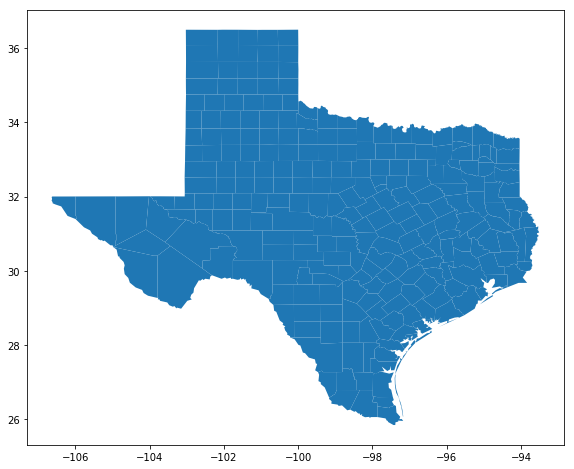

In [387]:
gdf.plot()

As you learned in class, neighborhoods (nearness) can be defined by contiguity, distance threshold (binary) or distance decay function (continuous).

The following codes generate spatial weight matrix using queen contiguity. 

![](images/fig14.jpg)

In [389]:
wq = Queen.from_dataframe(gdf)

Print the weights of each polygon

In [390]:
wq.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 26: [1.0, 1.0, 1.0, 1.0],
 27: [1.0, 1.0, 1.0, 1.0, 1.0],
 28: [1.0, 1.0, 1.0, 1.0, 1.0

print the neighbors of each polygon

In [391]:
wq.neighbors

{0: [4, 5, 6],
 1: [2, 3, 7, 8, 9],
 2: [8, 1, 9],
 3: [1, 4, 5, 7, 9],
 4: [0, 3, 5, 6, 7],
 5: [0, 3, 4, 6, 7, 11, 12, 13],
 6: [0, 4, 5, 12, 13],
 7: [1, 3, 4, 5, 9, 10, 11],
 8: [1, 2, 9, 10, 14],
 9: [1, 2, 3, 7, 8, 10, 11, 14],
 10: [16, 7, 8, 9, 11, 14, 15],
 11: [5, 7, 9, 10, 12, 15, 16, 18],
 12: [16, 17, 18, 5, 6, 11, 13],
 13: [17, 18, 5, 6, 12],
 14: [19, 8, 9, 10, 15],
 15: [16, 19, 21, 22, 10, 11, 14],
 16: [18, 22, 23, 10, 11, 12, 15],
 17: [18, 24, 25, 12, 13],
 18: [16, 17, 23, 25, 11, 12, 13],
 19: [20, 21, 14, 15],
 20: [32, 33, 19, 21],
 21: [32, 19, 20, 22, 31, 15],
 22: [16, 21, 23, 31, 30, 15],
 23: [16, 18, 22, 25, 28, 30],
 24: [17, 26, 29, 25],
 25: [17, 18, 23, 24, 28, 29],
 26: [24, 34, 27, 29],
 27: [34, 35, 50, 26, 47],
 28: [29, 23, 25, 43, 44, 45, 30],
 29: [34, 24, 25, 26, 43, 44, 28],
 30: [28, 22, 23, 44, 45, 46, 31],
 31: [32, 48, 21, 22, 30, 45, 46],
 32: [48, 33, 51, 20, 21, 46, 31],
 33: [32, 48, 51, 20],
 34: [49, 50, 43, 26, 27, 29],
 35: [50, 2

Standardize the weight matrix by rows

In [392]:
wq.transform='r'

In [393]:
wq.weights

{0: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 1: [0.2, 0.2, 0.2, 0.2, 0.2],
 2: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 3: [0.2, 0.2, 0.2, 0.2, 0.2],
 4: [0.2, 0.2, 0.2, 0.2, 0.2],
 5: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 6: [0.2, 0.2, 0.2, 0.2, 0.2],
 7: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 8: [0.2, 0.2, 0.2, 0.2, 0.2],
 9: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 10: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 11: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 12: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 13: [0.2, 0.2, 0.2, 0.2, 0.2

#### Plotting the neighborhood relations as a network
The map below show the neighborhood relations between the polygons (ciby boundaries) by lines linking their centroids. Polygons that are neighbors to each other are linked.

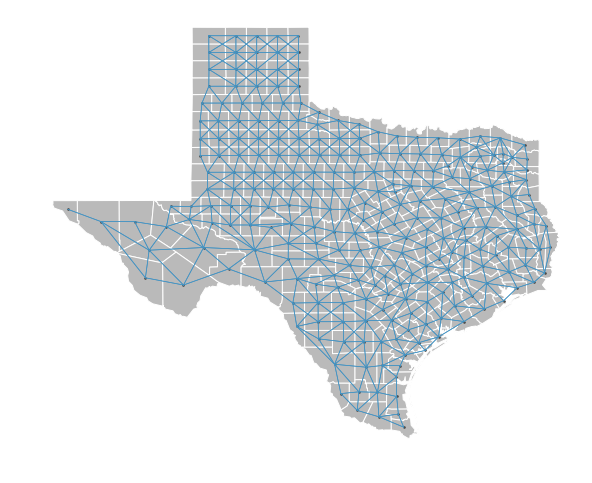

In [394]:
plot_spatial_weights(wq, gdf)
plt.show()

---

# Question 1

Please create a plot showing the neighborhood network based on the rook contiguity.

---

## Preview the Berlin airbnb dataset

Load the polygon shapefile of Berline neighborhoods. 

In [396]:
gdf = gpd.read_file('C:/Users/yi/Documents/UH_work/Teaching/GEOG389/labs/lab5_data/nbr.shp')

The data set comes from the Berlin airbnb scrape taken in April 2018. This dataframe was constructed as part of the [GeoPython 2018 workshop](https://github.com/ljwolf/geopython) by Levi Wolf and Serge Rey. As part of the workshop a geopandas data frame was constructed with one of the columns reporting the median listing price of units in each neighborhood in Berlin:


The attribute `median_pri` stores the listing price of airbnb the neighborhoods (in EUROs)

In [397]:
gdf.head(10)

,neighbourh,neighbou_1,median_pri,geometry
0,Blankenfelde/NiederschÃ¶nhausen,Pankow,37.5,"POLYGON ((392480.303433465 5830613.610922907, ..."
1,Helmholtzplatz,Pankow,58.0,"POLYGON ((392465.0500946037 5823316.093513586,..."
2,Wiesbadener StraÃe,Charlottenburg-Wilm.,50.0,"POLYGON ((385026.8651988263 5814426.288876688,..."
3,SchmÃ¶ckwitz/Karolinenhof/Rauchfangswerder,Treptow - KÃ¶penick,99.0,"POLYGON ((412208.2599996365 5805900.41319234, ..."
4,MÃ¼ggelheim,Treptow - KÃ¶penick,25.0,"POLYGON ((414129.8801232719 5807223.729199735,..."
5,Biesdorf,Marzahn - Hellersdorf,35.0,"POLYGON ((402765.2262294152 5821522.206273218,..."
6,Nord 1,Reinickendorf,31.0,"POLYGON ((387407.7580539181 5831593.762281329,..."
7,West 5,Reinickendorf,50.0,"POLYGON ((383603.19654782 5829115.59301448, 38..."
8,Frankfurter Allee Nord,Friedrichshain-Kreuzberg,42.0,"POLYGON ((395041.9090302421 5819647.302825218,..."
9,Buch,Pankow,57.5,"POLYGON ((396124.8960022511 5834505.19228738, ..."


Create a histogram to see the distribution of the airbnb prices.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000228E03FEBE0>]],
      dtype=object)

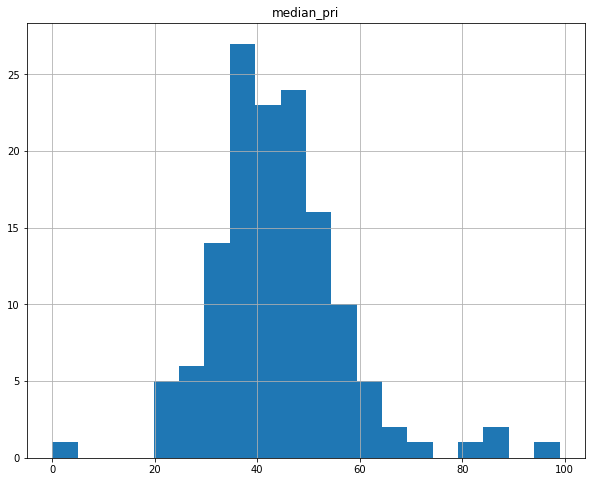

In [398]:
gdf.hist(bins=20)

Next, we will plot the median airbnb price (`median_pri`) in a choropleth map.

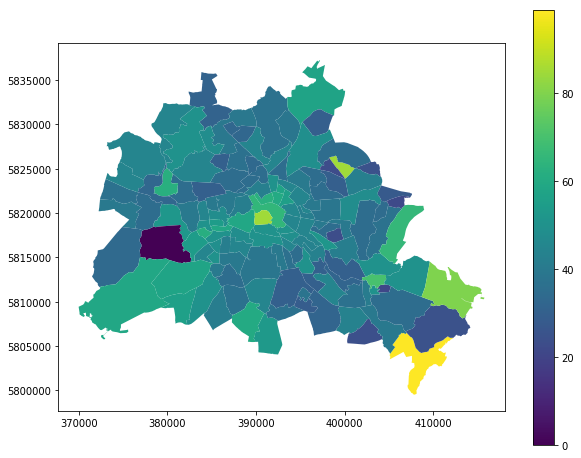

In [400]:
gdf.plot(column='median_pri',legend=True)

Plot using quantiles classification and green-blue color scheme. [Other color schemes](https://matplotlib.org/tutorials/colors/colormaps.html)

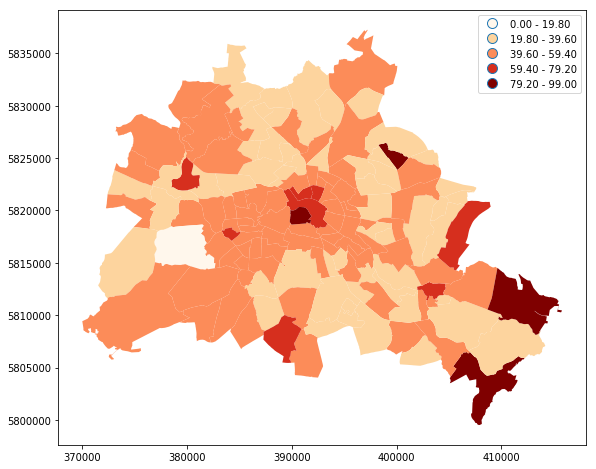

In [403]:
gdf.plot(column='median_pri', scheme='equal_interval', k=5, cmap='OrRd', legend=True)

# gdf.plot(column='median_pri', scheme='equal_interval', k=5, cmap='OrRd', legend=True)

## Spatial Autocorrelation

The choropleth map allows us to visually observe spatial pattern. If the spatial distribution of the prices was random, then we should not see any clustering of similar values on the map. However, our visual system is drawn to the darker clusters in the south west as well as the center, and a concentration of the lighter hues (lower prices) in the north central and south east.

Our brains are very powerful pattern recognition machines. However, sometimes they can be too powerful and lead us to detect false positives, or patterns where there are no statistical patterns. This is a particular concern when dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure.

Let's use PySAL to generate these two types of similarity measures.

# Spatial Similarity

We have already encountered spatial weights in a previous notebook. In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of spatial similarity (whether things are located near each other).

![](images/fig15.jpg)

Get the attribute of median price

In [404]:
y = gdf['median_pri']

Create a spatial weight matrix based on queen contiguity.

In [407]:
wq =  libpysal.weights.Queen.from_dataframe(gdf)
wq.transform = 'r'

Calculate the spatial lag of `median_pri`, which are averages of airbnb prices of the neighbors.

In [408]:
ylag = lps.weights.lag_spatial(wq, y)

gdf['lag_median_pri'] = ylag

Plot the spatial lags of polygons (neighborhoods) in Berlin.

The following plot shows the spatial lags in each polygon. The dark polygons are places where the average airbnb price in the neighborhood is high.

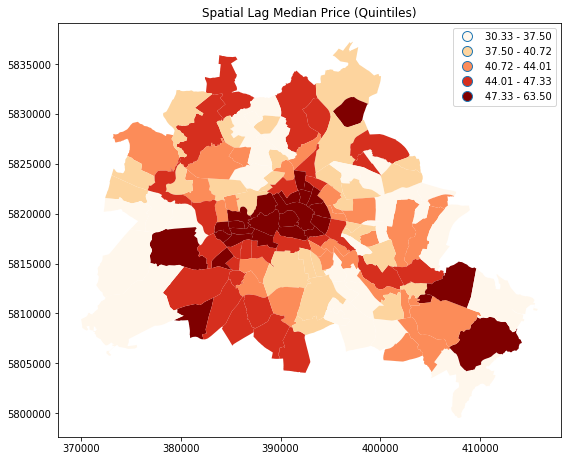

In [409]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(column='lag_median_pri', scheme='quantiles', k=5, cmap='OrRd', legend=True, ax=ax)
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

The quintile map for the spatial lag tends to enhance the impression of value similarity in space. It is, in effect, a local smoother.

The following code plots the prices and the spatial lags of median price.

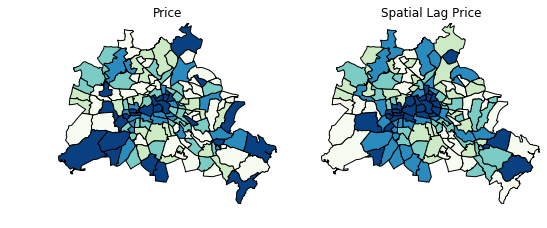

In [410]:
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
gdf.plot(column='median_pri', ax=ax[0], edgecolor='k',scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")


gdf.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")

ax[0].axis('off')
ax[1].axis('off')
plt.show()

## Global Spatial Autocorrelation

From the above fiture we can observe that the spatial distributions of the variable (price) and the spatial lag of the variable are similar, both clustered in city center. 

From the observation, you can infer a linear relationship between the variable and the spatial lag. The slope of the linear regression line is global spatial autocorrelation.

![](images/fig16.jpg)

Get the columns of median prices and spatial lags of median prices

In [411]:
price = gdf['median_pri']
lag_price = gdf['lag_median_pri']

Fit `price` (x: independent variable) and `lag_price` (y: dependent variable) in a linear equation (y=b*x+e)

b is the coefficient (the slope of the regression line) and e is the residual.

In [413]:
b, e = np.polyfit(price, lag_price, 1)

In [414]:
b

0.06941985459768148

Plot the scatter plot between the prices and the spatial lags of the prices.

Two lines are added to partition the scatter plot into four quadrats.

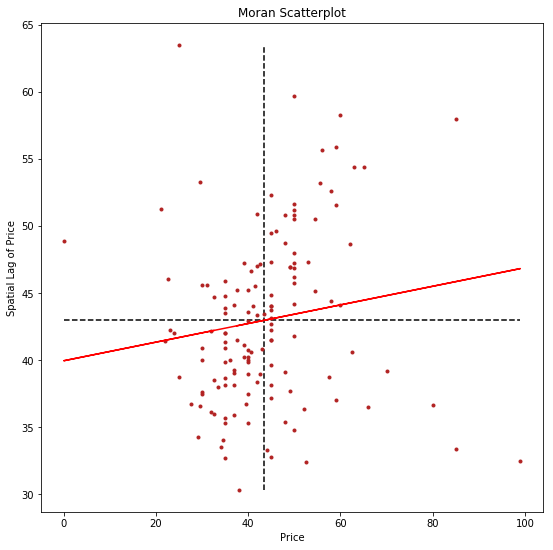

In [415]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, e + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()

The spatial autocorrelation is indicated by the slope of the regression line (i.e. b)

The four quadrats in the scatter plot indicates High-High (top-right), Low-Low (bottom-left), High-Low (top-right), and Low-High (bottom-left) polygons.

Instead of calculating the coefficient `b` in a linear regression model, we can use the `moran.Moran` function in the `esda` package to calculate Moran's I

In [417]:
mi = esda.moran.Moran(gdf['median_pri'], wq)

In [418]:
mi.I

0.06941985459768188

The p-value of Moran's I. 

Can be interpreted as the probability that the spatial pattern of the prices is random.

The smaller the p-value is, the more significant the test is.

In [419]:
mi.p_sim

0.063

Comparing the Moran's I of the airbnb price with the distribution of random simulation.

As can be observed in the histogram, the Moran's I of the airbnb prices is positively deviated from the mean of the random distribution, indicating the spatial autocorrelation is positive (a clustered pattern).

Text(0.5, 0, "Moran's I")

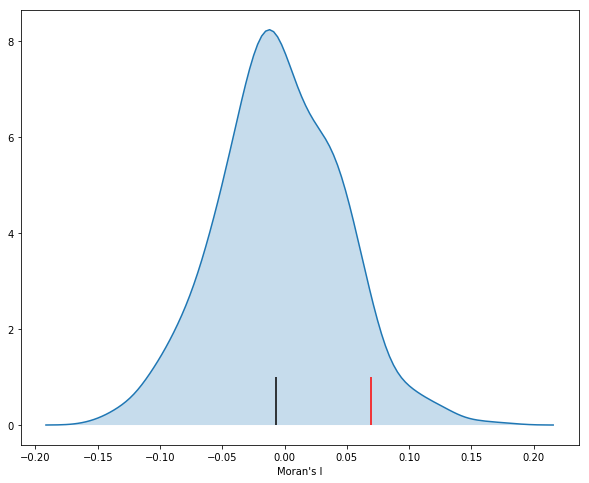

In [420]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

## Local Spatial Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers

The global spatial autocorrelation describes the overal spatial pattern in the entire study area. However, you can observe heterogenous pattersns at different local areas. Some places are clustered, some places are dispersed, some are like random.

Moran's I can be calculated in the focal area centered at each polygon, considering the spatial autocorrelation in the neighborhood of the polygon.

Calculate local Moran's I:

In [423]:
li = esda.moran.Moran_Local(y, wq)

Print which quadrant does each polygon is located. (1:HH, 2:LH, 3:LL, 4:HL)

In [424]:
li.q

array([2, 1, 1, 4, 2, 3, 2, 1, 3, 4, 3, 1, 3, 1, 1, 3, 3, 2, 3, 1, 1, 1,
       1, 2, 2, 3, 4, 4, 3, 4, 2, 3, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       2, 3, 3, 2, 2, 4, 3, 3, 3, 3, 1, 1, 1, 1, 4, 3, 4, 3, 3, 4, 2, 2,
       2, 4, 4, 3, 3, 4, 2, 4, 2, 4, 4, 1, 2, 1, 4, 3, 4, 2, 3, 3, 3, 3,
       3, 3, 4, 2, 4, 3, 4, 1, 1, 1, 3, 3, 1, 1, 1, 3, 4, 1, 4, 2, 3, 1,
       1, 2, 4, 2, 2, 2, 1, 1, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 3, 3])

Calculate the p-value of Local Moran's I.

In [425]:
li.p_sim

array([0.346, 0.071, 0.279, 0.09 , 0.003, 0.418, 0.293, 0.388, 0.452,
       0.236, 0.417, 0.114, 0.062, 0.007, 0.057, 0.175, 0.188, 0.116,
       0.026, 0.005, 0.214, 0.209, 0.123, 0.251, 0.1  , 0.3  , 0.07 ,
       0.084, 0.377, 0.368, 0.299, 0.056, 0.164, 0.232, 0.218, 0.438,
       0.011, 0.048, 0.014, 0.469, 0.041, 0.056, 0.04 , 0.212, 0.225,
       0.185, 0.116, 0.155, 0.279, 0.499, 0.018, 0.356, 0.392, 0.054,
       0.054, 0.278, 0.238, 0.399, 0.151, 0.487, 0.468, 0.303, 0.103,
       0.022, 0.322, 0.126, 0.43 , 0.064, 0.028, 0.486, 0.261, 0.052,
       0.474, 0.434, 0.412, 0.203, 0.402, 0.221, 0.29 , 0.085, 0.172,
       0.287, 0.023, 0.35 , 0.432, 0.105, 0.185, 0.293, 0.286, 0.159,
       0.289, 0.447, 0.218, 0.349, 0.354, 0.178, 0.126, 0.315, 0.092,
       0.217, 0.075, 0.121, 0.12 , 0.209, 0.378, 0.42 , 0.084, 0.32 ,
       0.28 , 0.004, 0.049, 0.203, 0.212, 0.348, 0.413, 0.343, 0.084,
       0.376, 0.253, 0.294, 0.499, 0.413, 0.067, 0.251, 0.059, 0.02 ,
       0.054, 0.309,

Classify the polygons into four types of patterns. 

Only polygons where p < 0.05 are considered significant.

In [429]:
hotspot = gdf[(li.p_sim<0.05) & (li.q==1)]
coldspot = gdf[(li.p_sim<0.05) & (li.q==3)]
low_high = gdf[(li.p_sim<0.05) & (li.q==2)]
high_low = gdf[(li.p_sim<0.05) & (li.q==4)]

Plot the hot spots.

[Color codes of matplotlib](https://matplotlib.org/2.0.0/examples/color/named_colors.html).

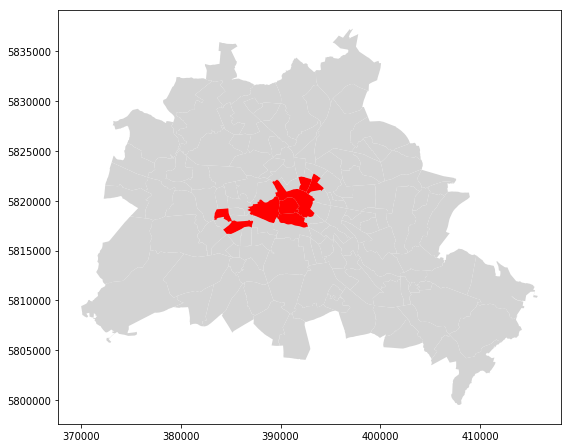

In [432]:
f, ax = plt.subplots(1, figsize=(9, 9))

gdf.plot(color='lightgray',ax=ax)
hotspot.plot(color='red',ax=ax)

---

## Question 2

Following the instruction, create a plot to show cold spots (Low-Low), low-high, and high-low polygons in four different maps.

Please assign color in the following way:
 - cold spots: blue
 - low-high: lightblue
 - high-low: pink

## Question 3

Plot the four types of spatial patterns (hot spot, cold spots, low-high, and high-low) in a single map.

Please assign color in the following way:
 - hot spots: red
 - cold spots: blue
 - low-high: lightblue
 - high-low: pink